In [47]:
import numpy as np
from scipy.integrate import quad, quad_vec
import scipy.integrate as integrate
from scipy.special import erf
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
from classy import Class
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import LogLocator, MultipleLocator

In [48]:
zci=20
G = 6.67430e-11 # m^3 s^-3 kg^-1
M_sun = 1.98847e30
Mpc_to_m = 3.08567758149e22
m_to_Mpc = Mpc_to_m**-1
kg_to_M_sun = 5.02785e-31

cosmo = Class()
cosmo.set({'omega_b':0.0223828,'Omega_m':0.3166,'theta_s_100':1.04090,'A_s':2.101549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
cosmo.set({'output':'mPk,dTk','P_k_max_1/Mpc':15.0,'z_max_pk':1000,'z_pk': 950})
cosmo.compute()

H0_SI = 100. * cosmo.h() * 3.24077929e-20
rho_crit = 3 * H0_SI**2 / (8 * np.pi * G)* ((Mpc_to_m**3) / M_sun)

D_initial=cosmo.scale_independent_growth_factor(zci)
D_prime_initial=-(cosmo.scale_independent_growth_factor_f(zci))*(cosmo.scale_independent_growth_factor(zci))/(1+zci)
rho_initial = rho_crit * cosmo.h()**2 * cosmo.Omega_m() * (1 + zci)**3 
rho_Lambda = rho_crit * cosmo.h()**2 * (1. - cosmo.Omega_m())
initial_conditions = [D_initial, D_prime_initial,rho_initial]



In [49]:
rs=np.arange(0.1,600,0.1)
sigmain=np.array([((cosmo.sigma(i, zci, h_units=True))/(cosmo.scale_independent_growth_factor(zci))) for i in rs])
interpsigmain=interpolate.CubicSpline(rs,sigmain)
derinterpsigmain=interpsigmain.derivative()

def sigmazin(R):
    b=interpsigmain(R)
    return b
        
def dsigmadr(R):
    a=derinterpsigmain(R) 
    b=interpsigmain(R)
    return a/b

In [50]:
#Note that sigma and R are not independent! I am just speeding up (since [(sigma,r)/(sigma)] is time independent)

def multip_func_void(R,sigma,deltac,deltav):
    
    capD = -deltav/(deltac - deltav)
    x = -sigma*capD/deltav
    nuv = -deltav/sigma
    df = np.where(x <= 0.276, 
                  np.sqrt(2/np.pi)*nuv*np.exp(-nuv**2/2), # if condition == True
                  np.sum(np.array([(2*np.exp(-(i*np.pi*x)**2/2)*i*np.pi*x**2*np.sin(i*np.pi*capD)) for i in [1,2,3,4]]), axis=0))
    return -df * dsigmadr(R)


#missing the -dot{D}/D factor 

def der_multip_func_void(R,sigma,deltac,deltav):

    capD=(-deltav)/(-deltav + deltac)
    x=(sigma*capD)/deltav
    nuv=-deltav/sigma
    
    df = np.where(x <= 0.276, 
                  np.sqrt(2/np.pi)*nuv*np.exp(-nuv**2/2)*(1-nuv**2),
                  np.sum(np.array([(-2+(np.pi*i*x)**2)*2*np.exp(-(i*np.pi*x)**2/2)*i*np.pi*x**2*np.sin(i*np.pi*capD)  for i in [1,2,3,4]]),axis=0))
    return -df * dsigmadr(R)

## Hardcode (part of) f'' = (following, missing the (Dot{D}/D)^2 ) + (-D''/D)(der_multip_func_PS)

def sec_der_multip_func_void(R,sigma,deltac,deltav):

    capD=(-deltav)/(-deltav + deltac)
    x=(sigma*capD)/deltav
    nuv=-deltav/(np.sqrt(2)*sigma)
    
    df = np.where(x <= 0.276, 
                  np.sqrt(2/np.pi)*nuv*np.exp(-nuv**2/2)*(2-5*nuv**2+nuv**4),
                  np.sum(np.array([(2-5*(np.pi*i*x)**2+(np.pi*i*x)**4)*2*np.exp(-(i*np.pi*x)**2/2)*i*np.pi*x**2*np.sin(i*np.pi*capD)  for i in [1,2,3,4]]),axis=0))
    return -df * dsigmadr(R)

                  
def multip_func_PS(R,sigma,delta):

    nu=delta/sigma
    df=np.sqrt(2/np.pi)*nu*np.exp(-nu**2/2)    
    return -df*dsigmadr(R)

# The one below misses the -dot{D}/D factor 
def der_multip_func_PS(R,sigma,delta):
    
    nu=delta/sigma
    df=np.sqrt(2/np.pi)*nu*np.exp(-nu**2/2)*(1-nu**2)
    return -df*dsigmadr(R)

# Hardcode (part of) f'' = (following, missing the (Dot{D}/D)^2 ) + (-D''/D)(der_multip_func_PS)

def sec_der_multip_func_PS(R,sigma,delta):
    nu=delta/sigma
    df=np.sqrt(2/np.pi)*nu*np.exp(-nu**2/2)*(2-5*nu**2+nu**4)
    return -df*dsigmadr(R)

In [51]:
# define the scales for the integrations in R. Change xbin for less or more precision
Rbin=0.05

z=np.arange(0,zci,0.01)
# flip required for the odeint in redshifts
zf=np.flip(z)

# Main piece
def solnum(scalec,scalev):
    rrangec=np.arange(scalec,71,Rbin)
    rrangev=np.arange(scalev,71,Rbin)
    sigmarzic=interpsigmain(rrangec)
    sigmarziv=interpsigmain(rrangev)
    def equations(y,z):
        D,D_prime,rho=y
        sigmaric= D*sigmarzic
        sigmariv= D*sigmarziv
#         computation of the total fractions of proto-haloes and proto-voids 
        integrandv1=multip_func_void(rrangev,sigmariv,1.68,-2.81) 
        integrandv2=multip_func_void(rrangev,sigmariv,1.68,-1)
        integrandh1=multip_func_PS(rrangec,sigmaric,1.68)
        integrandh2=multip_func_PS(rrangec,sigmaric,1.06)
        Fractionv1=integrate.simpson(integrandv1,rrangev)
        Fractionv2=integrate.simpson(integrandv2,rrangev)
        Fractionh1=integrate.simpson(integrandh1,rrangec)
        Fractionh2=integrate.simpson(integrandh2,rrangec)
        Fv= Fractionv2-Fractionv1
        Fh= Fractionh2-Fractionh1
        F= Fv+Fh
        Eic1= -5/3*rho*1.68/5.62*Fractionh1
        Eic2= -5/3*rho*1.06/1.77*Fractionh2
        Eiv1=5/3*rho*2.8*Fractionv1
        Eiv2=5/3*rho*1.28/1.7*Fractionv2
        EioverVhalo= Eic2 - Eic1
        EioverVvoid= Eiv2 - Eiv1
        EioverV = EioverVhalo + EioverVvoid
        
        #Number densities and calculation of dot{E_int}.
        
        #derivatives
    
        derFractionv1=integrate.simpson(der_multip_func_void(rrangev,sigmariv,1.68,-2.81),rrangev)
        derFractionv2=integrate.simpson(der_multip_func_void(rrangev,sigmariv,1.68,-1),rrangev)
        derFractionh1=integrate.simpson(der_multip_func_PS(rrangec,sigmaric,1.68),rrangec)
        derFractionh2=integrate.simpson(der_multip_func_PS(rrangec,sigmaric,1.06),rrangec)
        der_Eic1=-(5/3)*rho*(1.68/5.62)*derFractionh1
        der_Eic2=-(5/3)*rho*(1.06/1.77)*derFractionh2
        der_Eiv1=(5/3)*rho*(2.8)*derFractionv1
        der_Eiv2=(5/3)*rho*(1.28/1.7)*derFractionv2
        x= -D_prime/D*(der_Eic2-der_Eic1 + der_Eiv2 - der_Eiv1)
        
        wtot= (1+z)/(3*rho)*x/(1-EioverV/rho)
        
    #ODE's to be solved
        
        drho_dz=3/(1+z)*rho*(1+wtot)
        dD_prime_dz= D_prime/(1+z)*(1-3/2*rho/(rho+rho_Lambda)*(1+wtot))  + 3/(2*(1+z)**2)*rho/(rho_Lambda + rho)*(1-F)*D
        return [D_prime,dD_prime_dz,drho_dz]

    solution = odeint(equations, initial_conditions, zf)

    return solution

In [52]:
#Cosmology Functions

def numsol(scalec,scalev):
    system=solnum(scalec,scalev)
    return system

def D(scalec,scalev):
    d=numsol(scalec,scalev)[:,0]
    return d

def D_prime(scalec,scalev):
    d=numsol(scalec,scalev)[:,1]
    return d

def rho_tot(scalec,scalev):
    d=numsol(scalec,scalev)[:,2]
    return d

def Hubble(scale1,scale2):
    H=(((rho_tot(scale1,scale2))/(rho_crit) + rho_Lambda/(rho_crit))*100**2)**(1/2)
    return H

def Omegam(scalec,scalev):
    om=((rho_tot(scalec,scalev)/(rho_crit))*100**2)/(Hubble(scalec,scalev))**2
    return om

def s8(scale1,scale2):
    sigma8t=sigmazin(8)*D(scale1,scale2)
    return sigma8t

def fs8model(scale1,scale2):
    ft=-D_prime(scale1,scale2)/D(scale1,scale2)*(1+zf)
    sigma8t=sigmazin(8)*D(scale1,scale2)
    fs8t=ft*sigma8t
    return fs8t

In [53]:
# Smoothing limits - best fits of the model
scalec_true = 10**0.83
scalev_true = 10**0.66
# Re-define the G constant 
G_SI = 4.49e-15   # gravitational constant, Mpc^3/ (Gyrs^2 * Msolar)

# Convert to proper units, i.e.,
Gyrs_to_HT = 0.0690
Mpc_to_HL = 2.25e-4
c = 1 # correct speed of light, consistent with Ellis-Bruni formalism
G = G_SI * (Mpc_to_HL**3) / (Gyrs_to_HT**2) # convert to HL^2/(HT^2 * M_solar)

In [54]:
# Scale factor
def a(z):
    return (1+z)**(-1)

# Expansion scalar
def Theta(z):
    H_arr = (Hubble(scalec_true, scalev_true)* (1e3 / Mpc_to_m) * (3.1536e16))/Gyrs_to_HT  # array over zf
    # Create a cubic spline
    H_spline = CubicSpline(np.flip(zf), np.flip(H_arr))   
    return 3*H_spline(z)

# Total density
def rhotot(z):
    rhotot_arr = rho_tot(scalec_true, scalev_true)/(Mpc_to_HL**3)  # array over zf
    # Create a cubic spline
    rho_tot_spline = CubicSpline(np.flip(zf), np.flip(rhotot_arr)) 
    return rho_tot_spline(z)/cosmo.h()**2 

def wtot(z):
    rhotot_arr = rho_tot(scalec_true, scalev_true)/(Mpc_to_HL**3) # array over zf
    # Create a cubic spline
    rho_tot_spline = CubicSpline(np.flip(zf), np.flip(rhotot_arr)) 
    # Derivative d(rho)/dz
    drho_dz = rho_tot_spline.derivative()
    # Compute w_tot
    return ((1 + z) / 3) * drho_dz(z) / rho_tot_spline(z) - 1



In [55]:
def D_fun(z):
    D_arr = D(scalec_true, scalev_true)  # array over zf
    # Create a cubic spline
    D_spline = CubicSpline(np.flip(zf), np.flip(D_arr))   
    return D_spline(z)

def D_prime_fun(z):
    D_prime_arr = D_prime(scalec_true, scalev_true)  # array over zf
    # Create a cubic spline
    D_prime_spline = CubicSpline(np.flip(zf), np.flip(D_prime_arr))   
    return D_prime_spline(z)

def D_2prime_fun(z):
    D_prime_arr = D_prime(scalec_true, scalev_true)  # array over zf
    # Create a cubic spline
    D_prime_spline = CubicSpline(np.flip(zf), np.flip(D_prime_arr))   
    D_2prime = D_prime_spline.derivative()
    return D_2prime(z)

def H_prime_fun(z):
    H_arr = (Hubble(scalec_true, scalev_true) * (1e3 / Mpc_to_m) * (3.1536e16))/Gyrs_to_HT # array over zf right units
    # Create a cubic spline
    H_spline = CubicSpline(np.flip(zf), np.flip(H_arr)) 
    H_prime = H_spline.derivative()
    return H_prime(z)

def rholin(z):
    H = Theta(z)/3
    term1 = -2*D_prime_fun(z)*(1+z)*(H**2)
    term2 = D_2prime_fun(z)*((1+z)**2)*(H**2) + D_prime_fun(z)*(1+z)*(H**2) + D_prime_fun(z)*H_prime_fun(z)*H*((1+z)**2)
    num = term1 + term2
    den = 4*np.pi*G*D_fun(z)
    return (num/den)/cosmo.h()**2 

def rhod(z):
    rhobarzci = rho_initial/(Mpc_to_HL**3)
    return (rhobarzci/cosmo.h()**2) * (((1+zci)/(1+z))**(-3))

    

In [56]:
#Curvature
def RD(z):
    const = 8*np.pi*G/(c**2)
    term1 = -(rhotot(z)-rhod(z))
    term2 = rhotot(z)*wtot(z)
    return (3/2)*(term1+term2)*const

#Backreaction
def QD(z):
    const = 8*np.pi*G
    term1 = (rhotot(z)-rhod(z))
    term2 = 3*rhotot(z)*wtot(z)
    return (-1/2)*(term1+term2)*const

def rhoEff(z):
    return (-1/(16*np.pi*G))*(QD(z)+RD(z))

def pEff(z):
    return (-1/(16*np.pi*G))*(QD(z)) + (1/(48*np.pi*G))*(RD(z))

#Effective Eos
def wEff(z):
    return pEff(z)/rhoEff(z)

#Effective "sound" velocity
def cs2Eff(z):
    rho_Eff_arr = rhoEff(zf)
    p_Eff_arr = pEff(zf)
    rho_Eff_spline = CubicSpline(np.flip(zf), np.flip(rho_Eff_arr))
    p_Eff_spline = CubicSpline(np.flip(zf), np.flip(p_Eff_arr))
    drhoEff_dz = rho_Eff_spline.derivative()
    dpEff_dz = p_Eff_spline.derivative()
    return dpEff_dz(z)/drhoEff_dz(z)


In [57]:
# Extract quantities of interest to check the energy balance 
RDarr = RD(zf)
QDarr = QD(zf)
Harr = Theta(zf)/3
af = a(zf)
# Convert in normalised quantities
OmegaR = -(c**2)*RDarr/(6*Harr**2)
OmegaQ = -QDarr/(6*Harr**2)
OmegaM = 8*np.pi*G*rhod(zf)/(3*Harr**2)
OmegaL = 1.0 - OmegaM - OmegaR - OmegaQ
Lambda = OmegaL[-1]*3*(Harr[-1]**2) # Extract Lambda for background studies

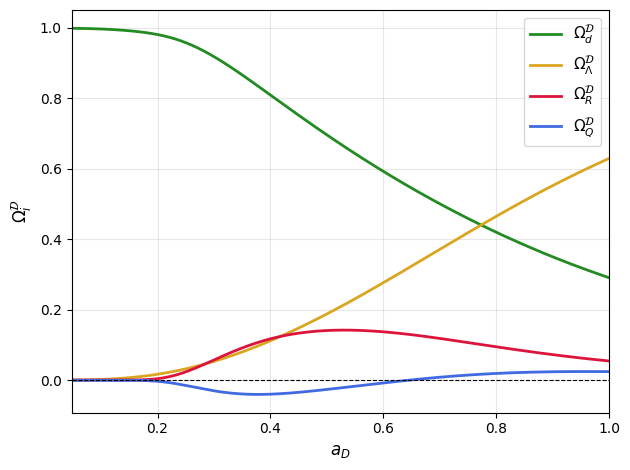

In [58]:
# Plot
plt.plot(af, OmegaM, label=r'$\Omega^\mathcal{D}_d$', color='forestgreen', lw=2)
plt.plot(af, OmegaL, label=r'$\Omega^\mathcal{D}_\Lambda$', color='goldenrod', lw=2)
plt.plot(af, OmegaR, label=r'$\Omega^\mathcal{D}_R$', color='crimson', lw=2)
plt.plot(af, OmegaQ, label=r'$\Omega^\mathcal{D}_Q$', color='royalblue', lw=2)
plt.axhline(0, color='k', linestyle='--', lw=0.8)
plt.xlabel(r'$a_D$', fontsize=12)
plt.ylabel(r'$\Omega^\mathcal{D}_i$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([af[0],af[-1]])
plt.tight_layout()
plt.savefig('GMC_energy_balance.pdf', format='pdf')
plt.show()

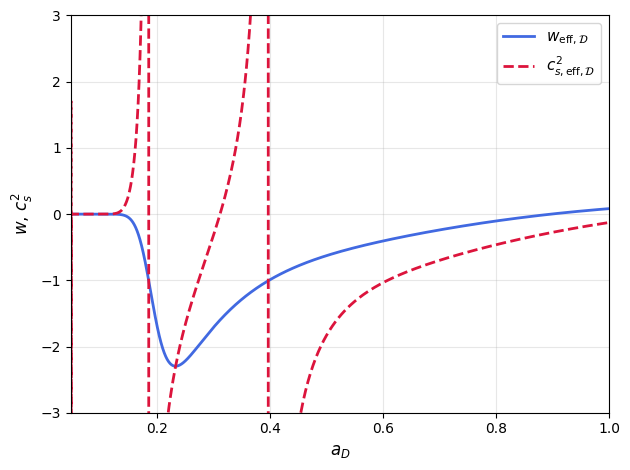

In [59]:
plt.plot(af, wEff(zf), label=r'$w_{\mathrm{eff},\mathcal{D}}$', color='royalblue', lw=2)
plt.plot(af, cs2Eff(zf), '--', label=r'$c_{s,\mathrm{eff},\mathcal{D}}^2$', color='crimson', lw=2)
plt.xlabel(r'$a_D$', fontsize=12)
plt.ylabel(r'$w$, $c_{s}^2$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([af[0],af[-1]])
plt.ylim([-3,3])
plt.tight_layout()
plt.savefig('GMC_wcs.pdf', format='pdf')
plt.show()


In [60]:
# Precompile everything to speed up perturbations calculations: arrays evalutation
rhod_array = rhod(zf)
rhoEff_array = rhoEff(zf)
wEff_array = wEff(zf)
cs2Eff_array = cs2Eff(zf)
a_array = a(zf)
Theta_array = Theta(zf)

In [61]:
# Precompile everything: splines building
rhod_myspline = CubicSpline(np.flip(zf), np.flip(rhod_array))
rhoEff_myspline = CubicSpline(np.flip(zf), np.flip(rhoEff_array))
wEff_myspline = CubicSpline(np.flip(zf), np.flip(wEff_array))
cs2Eff_myspline = CubicSpline(np.flip(zf), np.flip(cs2Eff_array))
a_myspline = CubicSpline(np.flip(zf), np.flip(a_array))
Theta_myspline = CubicSpline(np.flip(zf), np.flip(Theta_array))
Theta_prime_myspline = Theta_myspline.derivative()

In [62]:
# Pre-compiled functions to use 
def a_pr(z):
    return float(a_myspline(z))

def Theta_pr(z):
    return float(Theta_myspline(z))

def rhod_pr(z):
    return float(rhod_myspline(z))

def rhoEff_pr(z):
    return float(rhoEff_myspline(z))

def wEff_pr(z):
    return float(wEff_myspline(z))

def cs2Eff_pr(z):
    return float(cs2Eff_myspline(z))

def zdot_pr(z):
    return float(-(1+z)*Theta_myspline(z)/3)

def H_pr(z):
    return float(Theta_myspline(z)/3)

def H_prime_pr(z):
    return float(Theta_prime_myspline(z)/3)

In [63]:
def solnum_barotropic(k,z_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(z):
        return -4*np.pi*G*rhod_pr(z)

    def A22(z):
        return -(2/3)*Theta_pr(z)

    def A23(z):
        term1 = -4*np.pi*G*rhoEff_pr(z)
        term2 = 1+3*cs2Eff_pr(z)
        return term1*term2

    def A32(z):
        return -(1+wEff_pr(z))

    def A33(z):
        return (wEff_pr(z)+cs2Eff_pr(z))*Theta_pr(z)

    def A34(z):
        return (k**2)/a_pr(z)

    def A43(z):
        return -cs2Eff_pr(z)/a_pr(z)

    def A44(z):
        term1 = Theta_pr(z)/3
        term2 = 3*wEff_pr(z)-1
        return term1*term2
    # Define a 4x4 redshift-dependent matrix A(z) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_eff; 4. Tilt_eff*(1+wEff)
    def A(z):
        return (1/zdot_pr(z))*np.array([
            [  0,        -1,        0,          0   ],
            [A21(z),    A22(z),   A23(z),       0   ],
            [  0,       A32(z),   A33(z),     A34(z)],
            [  0,         0,      A43(z),     A44(z)]
        ])
    
    # Define the ODE system: dv/dz = A(z) @ v
    def system(z, v):
        return A(z) @ v
    
    z_span = np.array([z_eval[0],z_eval[-1]])
    # Solve the system
    sol = solve_ivp(system, z_span, ic, t_eval=z_eval)  

    return sol

In [64]:
def solnum_comoving(z_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(z):
        return -4*np.pi*G*rhod_pr(z)

    def A22(z):
        return -(2/3)*Theta_pr(z)

    def A23(z):
        return -4*np.pi*G*rhoEff_pr(z)

    def A32(z):
        return -(1+wEff_pr(z))

    def A33(z):
        return wEff_pr(z)*Theta_pr(z)

    # Define a 3x3 redshift-dependent matrix A(z) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_eff;
    def A(z):
        return (1/zdot_pr(z))*np.array([
            [  0,        -1,        0     ],
            [A21(z),    A22(z),   A23(z)  ],
            [  0,       A32(z),   A33(z)  ]
        ])
    
    # Define the ODE system: dv/dz = A(z) @ v
    def system(z, v):
        return A(z) @ v
    
    z_span = np.array([z_eval[0],z_eval[-1]])
    # Remove the V_Eff initial condition
    ic_new = ic[:-1]
    # Solve the system
    sol = solve_ivp(system, z_span, ic_new, t_eval=z_eval)  

    return sol

In [65]:
# Mezaros Approximation
def solnum_mezaros(z_eval,ic):

    def perturbation_equation(z,y):
        delta, delta_dot = y
        H = Theta_pr(z)/3
        Hprime = H_prime_pr(z)
        rho_t = rhod_pr(z)
        delta_ddot = (4 * np.pi * G * rho_t * delta - 2 * H * (1+z) * (Hprime * (1+z) - H) * delta_dot)/(((1+z) * H)**2)
        return [delta_dot, delta_ddot]
    
    z_span = np.array([z_eval[0],z_eval[-1]])
    factor = zdot_pr(z_eval[0])**(-1)
    ic_new = np.array([ic[0],-ic[1]*factor])
    
    sol = solve_ivp(perturbation_equation,z_span,ic_new,t_eval=z_eval)

    return sol

In [66]:
# Redshift range and evaluation points
z_span = (zci, 0)

# Initial condition (4D vector) fixed to be the initial condition for a typical dust perturbation on a co-moving scale of 150 Mpc/h at present time in the concordance model
ic = [0.0031427229788258105, -0.16974050039281288, 0, 0]
z_eval = np.flip(np.arange(0,zci-0.01,0.01))

In [67]:
#Run the solver
sol_comoving = solnum_comoving(z_eval,ic)
sol_mezaros = solnum_mezaros(z_eval,ic)

/tmp/ipykernel_2457/3082914449.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


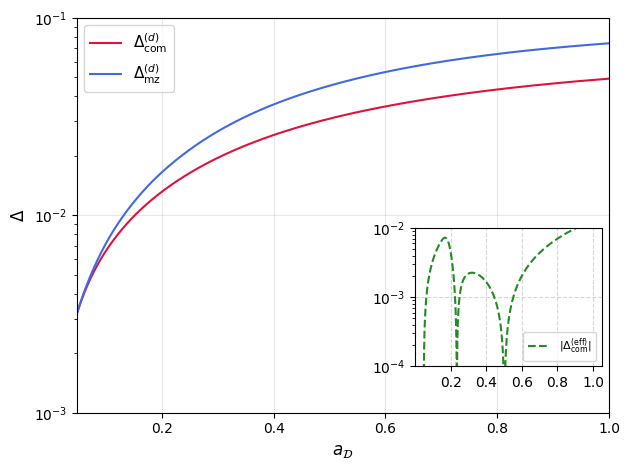

In [68]:
#Plot each component of the solution
fig, ax = plt.subplots()

labels_com = [r'$\Delta^{(d)}_{\mathrm{com}}$', r'$|\Delta^{(\mathrm{eff})}_{\mathrm{com}}|$']
labels_mz = [r'$\Delta^{(d)}_{\mathrm{mz}}$']

ax.plot([a_pr(z) for z in sol_comoving.t], sol_comoving.y[0], label=labels_com[0], color='crimson')
ax.plot([a_pr(z) for z in sol_mezaros.t], sol_mezaros.y[0], label=labels_mz[0], color='royalblue')

ax.set_xlabel(r'$a_{\mathcal{D}}$', fontsize=12)
ax.set_ylabel(r'$\Delta$', fontsize=12)
ax.set_xbound(a_pr(zci), af[-1])
ax.set_yscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e-1])
ax.grid(alpha=0.3)
ax.legend(fontsize=11)
# Inset axes (zoomed box)
ax_inset = inset_axes(ax, width="35%", height="35%", loc='lower right',
                      bbox_to_anchor=(-0.001, 0.1, 1, 1), bbox_transform=ax.transAxes) 

# Plot effective perturbation
ax_inset.plot([a_pr(z) for z in sol_comoving.t], np.abs(sol_comoving.y[2]), '--', color='forestgreen', label=labels_com[1])
ax_inset.set_yscale('log')
ax_inset.set_ylim([1e-4,1e-2])

# Finer grid
ax_inset.set_yticks([1e-4, 1e-3, 1e-2])
ax_inset.xaxis.set_major_locator(MultipleLocator(0.2))  # adjust depending on your x-range
ax_inset.grid(alpha=0.5, linestyle='--')
ax_inset.legend(fontsize=8)
plt.tight_layout()
plt.savefig('All_Perturbations_GMC.pdf', format='pdf')
plt.show()

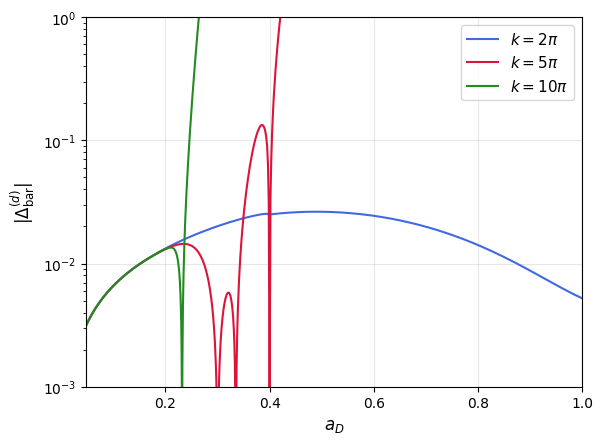

In [69]:
k_vector = [2*np.pi, 5*np.pi, 10*np.pi]
labels_k = [r'$k = 2\pi$',r'$k = 5\pi$',r'$k = 10\pi$']
sol_bar = {}
colors = ['royalblue','crimson','forestgreen']

for i in range(len(k_vector)):
    k = k_vector[i]
    sol_bar[k] = solnum_barotropic(k,z_eval,ic)
    plt.plot([a(z) for z in sol_bar[k].t], np.abs(sol_bar[k].y[0]), label=labels_k[i], color = colors[i])
    
plt.ylim([1e-3,1])
plt.yscale('log')
plt.xlabel(r'$a_D$', fontsize=12)
plt.ylabel(r'$|\Delta^{(d)}_\mathrm{bar}|$', fontsize=12)
plt.xlim([a(zci),af[-1]])
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.savefig('Bar_Dusts_GMC.pdf', format='pdf')
plt.show()

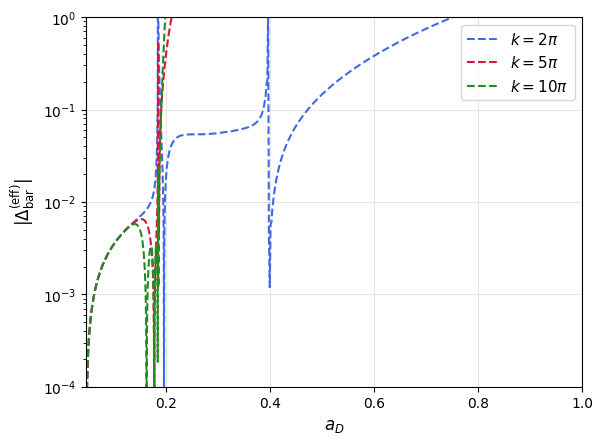

In [70]:
for i in range(len(k_vector)):
    k = k_vector[i]
    plt.plot([a(z) for z in sol_bar[k].t], np.abs(sol_bar[k].y[2]), '--', label=labels_k[i], color = colors[i])
    

plt.ylim([1e-4,1])
plt.yscale('log')
plt.xlabel(r'$a_D$', fontsize=12)
plt.ylabel(r'$|\Delta^{\mathrm{(eff)}}_\mathrm{bar}|$', fontsize=12)
plt.xlim([a(zci),af[-1]])
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.savefig('Bar_eff_GMC.pdf', format='pdf')
plt.show()